In [1]:
!pip install opencv-contrib-python --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample.jpg


In [3]:
image = cv2.imread('sample.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
sift = cv2.SIFT_create()
keypoints_sift, descriptors_sift = sift.detectAndCompute(gray, None)

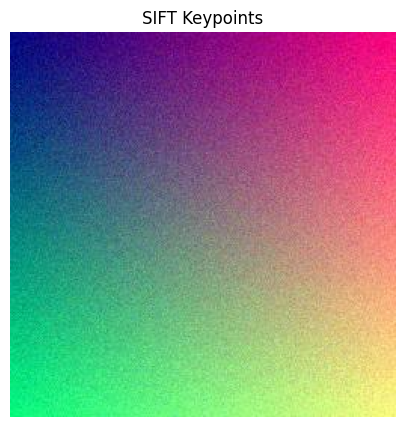

In [5]:
image_sift = cv2.drawKeypoints(image, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,5))
plt.title("SIFT Keypoints")
plt.imshow(cv2.cvtColor(image_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
orb = cv2.ORB_create()
keypoints_orb1, descriptors_orb1 = orb.detectAndCompute(gray, None)
keypoints_orb2, descriptors_orb2 = orb.detectAndCompute(gray, None)

In [7]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_orb1, descriptors_orb2)

In [8]:
matches = sorted(matches, key=lambda x: x.distance)

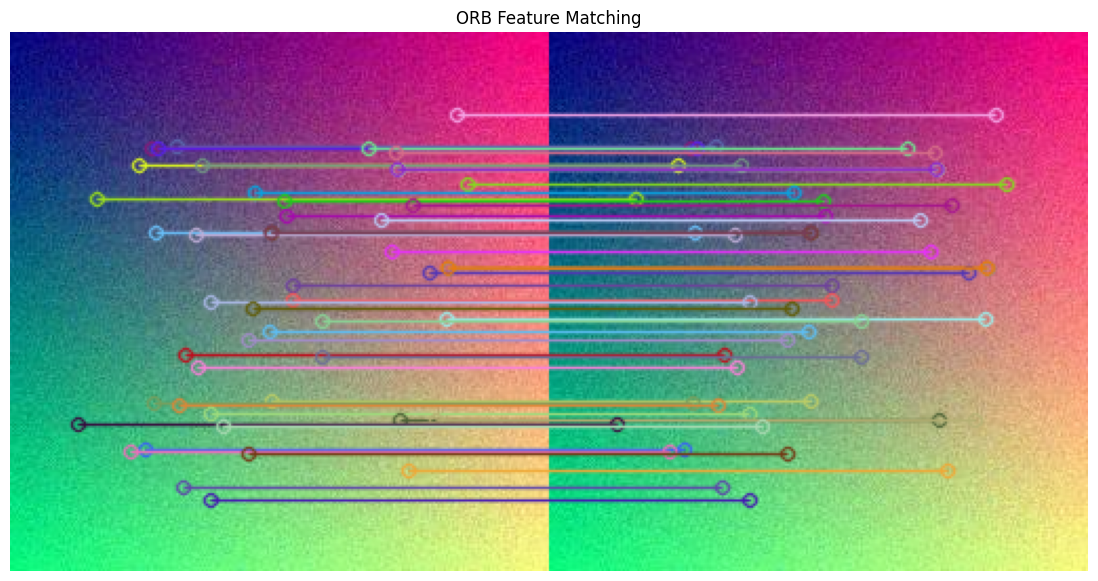

In [9]:
image_matches = cv2.drawMatches(image, keypoints_orb1, image, keypoints_orb2, matches[:50], None, flags=2)

plt.figure(figsize=(15,7))
plt.title("ORB Feature Matching")
plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
ret, thresh = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

In [11]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


In [12]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [13]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

In [14]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

In [15]:
ret, markers = cv2.connectedComponents(sure_fg)

In [16]:
markers = markers + 1

In [17]:
markers[unknown == 255] = 0

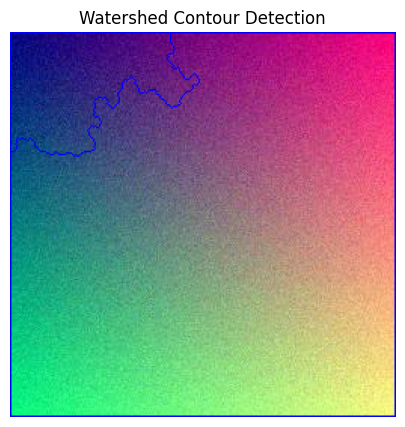

In [18]:
markers = cv2.watershed(image, markers)
image_contour = image.copy()
image_contour[markers == -1] = [255, 0, 0]  # Mark boundaries with red

plt.figure(figsize=(10,5))
plt.title("Watershed Contour Detection")
plt.imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

task 2

In [19]:
!pip install tensorflow --quiet

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [20]:
uploaded = files.upload()

Saving forest.jpg to forest.jpg


In [21]:
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [22]:
model = InceptionV3(weights='imagenet')

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
predictions = model.predict(img_array)
decoded_preds = decode_predictions(predictions, top=3)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


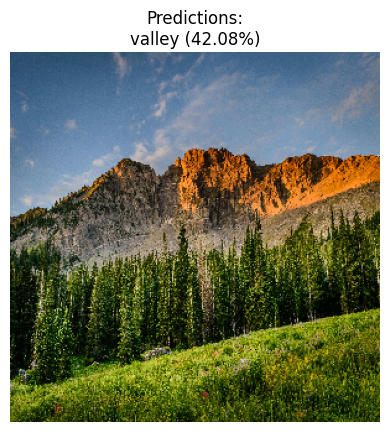

Top Predictions:
1. valley: 42.08%
2. alp: 36.00%
3. cliff: 9.16%


In [24]:
plt.imshow(img)
plt.axis('off')
plt.title(f"Predictions:\n{decoded_preds[0][1]} ({decoded_preds[0][2]*100:.2f}%)")
plt.show()

print("Top Predictions:")
for idx, (imagenetID, label, prob) in enumerate(decoded_preds):
    print(f"{idx+1}. {label}: {prob*100:.2f}%")

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [26]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(784, activation='sigmoid')  # 28x28 = 784
    ])
    return model

In [28]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [29]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
import tqdm

epochs = 2000
batch_size = 64

for epoch in tqdm.tqdm(range(epochs)):
    # Train discriminator
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict(noise, verbose=0)
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

    X = np.vstack([generated_images, real_images])
    y = np.vstack([np.zeros((batch_size,1)), np.ones((batch_size,1))])

    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y)

100%|██████████| 2000/2000 [03:34<00:00,  9.33it/s]


In [32]:
    noise = np.random.normal(0, 1, (batch_size, 100))
    y_gen = np.ones((batch_size, 1))

    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

In [33]:
   if epoch % 500 == 0:
        noise = np.random.normal(0, 1, (1, 100))
        generated_image = generator.predict(noise, verbose=0).reshape(28,28)
        plt.imshow(generated_image, cmap='gray')
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.axis('off')
        plt.show()